In [226]:
from chirho_diffeqpy import DiffEqPy, ATempParams, PureDynamics
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union, Callable
from functools import partial
from numbers import Real
import matplotlib.pyplot as plt
from typing import List
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoDiagonalNormal
from contextlib import nullcontext
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy
from contextlib import ExitStack, nullcontext
from pyro.contrib.autoname import scope
# Global params are weird.
from functools import singledispatch, partial
import pyro
import torch
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import easy_guide
from collections import namedtuple
from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel

pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(6237830)

In [227]:
def sinusoid_dynamics(state: State, atemp_params: ATempParams):
    frequency = atemp_params['frequency']
    amplitude = atemp_params['amplitude']
    decay = atemp_params['decay']
    t = state['t']
    
    return dict(
        # The time derivative of a sin wave, plus a decay term.
        y=amplitude * frequency * np.cos(frequency * t) - decay*state['y']
    )

SOLVER = DiffEqPy()

In [228]:
def sinusoid_param_prior():
    return dict(
        frequency=sample("frequency", dist.Uniform(0.1, torch.pi)),
        amplitude=sample("amplitude", dist.Uniform(0.1, 2.0)),
        decay=sample("decay", dist.Uniform(0.01, 1.0))
    )


def add_observation_noise(state):
    y = state['y']
    return dict(
        obs_y=sample("obs_y", dist.Normal(y, 0.1).to_event(1))
    )

def observation_noise_model(state) -> None:
    # The StaticBatchObservation obs function needs to return None.
    add_observation_noise(state)

In [229]:
def stochastic_jump_model(num_jumps: int, start_time: torch.Tensor, end_time: torch.Tensor, noise_per_time_unit: float, fix_jump_times=False):
   
    # <Dynamics>
    initial_state = dict(
        y=torch.tensor(3.0)
    )
    
    sinusoid_params = sinusoid_param_prior()
    # </Dynamics>
    
    # <Jump Model>
    distance_remaining = end_time - start_time
    last_jump_time = start_time
    
    def jump_intervention_fn(val: torch.Tensor, jump_idx: int, noise: torch.Tensor):
        return val + sample(f"jump{jump_idx}", dist.Normal(0.0, noise))
    
    jump_interventions_list = []
    jump_times = []
    
    if fix_jump_times:
        normed_jump_times = torch.tensor([0.5] * num_jumps)
    else:
        with pyro.plate("jumps", num_jumps):
            # A normalized jump time ranging from 0-1, distributed as a symmetric and centered beta.
            normed_jump_times = sample(f"normed_jump_time", dist.Beta(torch.tensor(3.0), torch.tensor(3.0)))
    
    
    for i, normed_jump_time in enumerate(normed_jump_times):
        
        avg_jump_distance_remaining = distance_remaining / (num_jumps - i)
        
        # An expanded jump_time from the last jump to twice the average or to the end time, whichever is smaller.
        desired_range = avg_jump_distance_remaining * 2.
        jump_time = last_jump_time + normed_jump_time * torch.min(desired_range, distance_remaining)
        
        # The noise is proportional to the time between jumps.
        jump_noise = noise_per_time_unit * (jump_time - last_jump_time)
        
        jump_intervention = StaticIntervention(
            time=jump_time,
            intervention=dict(y=partial(jump_intervention_fn, jump_idx=i, noise=jump_noise))
        )
        jump_interventions_list.append(jump_intervention)
        jump_times.append(jump_time)
        
        # Update the distance remaining.
        distance_remaining = end_time - jump_time
        
        # Update the last jump time.
        last_jump_time = jump_time
    
    jump_interventions = ExitStack()
    [jump_interventions.enter_context(ji) for ji in jump_interventions_list]
    
    with jump_interventions:
        simulate(
            sinusoid_dynamics,
            initial_state,
            start_time,
            end_time,
            atemp_params=sinusoid_params,
        )
    # </Jump Model>
    
    return torch.stack(jump_times)

In [230]:
START_T = 0.0
END_T = 15.0
NOISE_PER_TIME_UNIT = 5.0
NUM_JUMPS = 1000
RES = 10000
TRUE_COEFS = dict(
    frequency=torch.tensor(1.0),
    amplitude=torch.tensor(1.0),
    decay=torch.tensor(0.3)
)

with SOLVER, LogTrajectory(times=torch.linspace(START_T, END_T, RES)) as lt, condition(data=TRUE_COEFS):
    jump_times = stochastic_jump_model(NUM_JUMPS, torch.tensor(START_T), torch.tensor(END_T), NOISE_PER_TIME_UNIT)
data = add_observation_noise(lt.trajectory)

In [231]:
def plot_trajectory(lt: LogTrajectory, data: dict, jump_times: List[torch.Tensor], data_times: Optional = None, jump_lw=0.01):
    plt.figure()
    plt.plot(data_times if data_times is not None else lt.times, data['obs_y'].detach(), linewidth=0.1)
    plt.plot(lt.times, lt.trajectory['y'].detach(), alpha=1.0, linewidth=1.0)
    for jump_time in jump_times:
        plt.axvline(jump_time.item(), color='red', linestyle='--', linewidth=jump_lw)

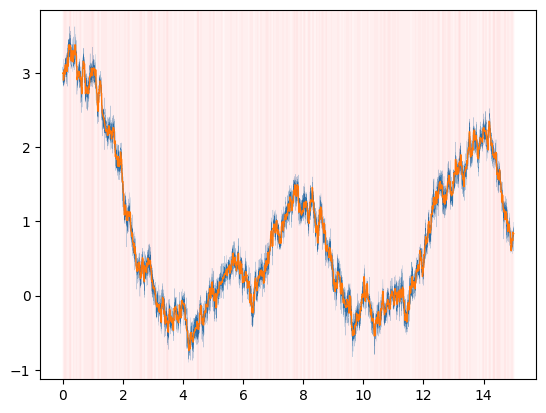

In [232]:
plot_trajectory(lt, data, jump_times, jump_lw=.03)

In [233]:
data_sub = {k: v[::20] for k, v in data.items()}
time_sub = lt.times[::20]
print(time_sub.shape)
print({k: v.shape for k, v in data_sub.items()})

torch.Size([500])
{'obs_y': torch.Size([500])}


In [301]:
# Using far fewer jumps than before. The idea is to have data from an actual SDE, and be fitting to that data with this loose approximation of one.
TRAIN_NUM_JUMPS = 50

In [234]:
_partial_jump_model = partial(
    stochastic_jump_model,
    num_jumps=TRAIN_NUM_JUMPS,
    start_time=torch.tensor(START_T),
    end_time=torch.tensor(END_T),
    noise_per_time_unit=NOISE_PER_TIME_UNIT,
)

# Train two models, one with fixed jump times and one with free jump times that will be optimized.
pjm_free_jump_times = partial(_partial_jump_model, fix_jump_times=False)
pjm_fixed_jump_times = partial(_partial_jump_model, fix_jump_times=True)

In [235]:
def conditioned_model(argless_model):
    with SOLVER, StaticBatchObservation(times=time_sub, observation=condition(data=data_sub)(observation_noise_model)):
        argless_model()

In [312]:
SVI = namedtuple('SVI', ['step', 'guide', 'losses'])

def build_svi(model, *args, variational_family=None, **kwargs,):
    if variational_family is None:
        variational_family = AutoDiagonalNormal
    guide = variational_family(model, *args, **kwargs)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    elbo()  # initialize parameters.
    optim = torch.optim.Adam(elbo.parameters(), lr=1e-2)
    losses = []
    
    def step():
        optim.zero_grad()
        loss = elbo()
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().item())
    
    return SVI(step, guide, losses)

In [237]:
svi_free = build_svi(partial(conditioned_model, argless_model=pjm_free_jump_times), init_loc_fn=pyro.infer.autoguide.init_to_median)
svi_fixed = build_svi(partial(conditioned_model, argless_model=pjm_fixed_jump_times), init_loc_fn=pyro.infer.autoguide.init_to_median)

In [266]:
NITER = 250
# This comes in handy only when running the bottom half of the notebook multiple times.
nbefore = len(svi_free.losses)
for i in range(NITER):
    svi_free.step()
    svi_fixed.step()
    print(f"Progress {nbefore + i + 1}/{nbefore + NITER}", end='\r')

In [267]:
def plot_losses(svi: SVI):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(svi.losses)
    ax2.plot(svi.losses[-300:])

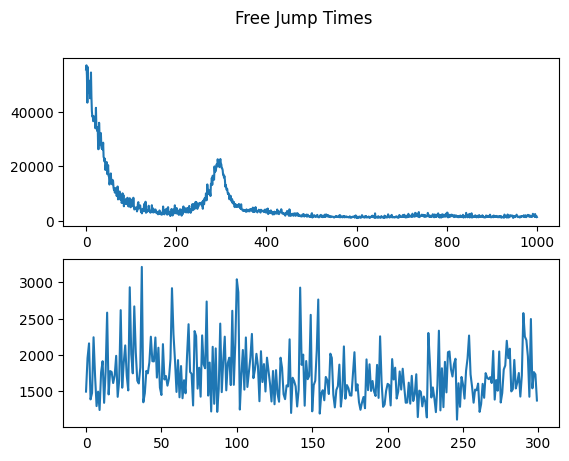

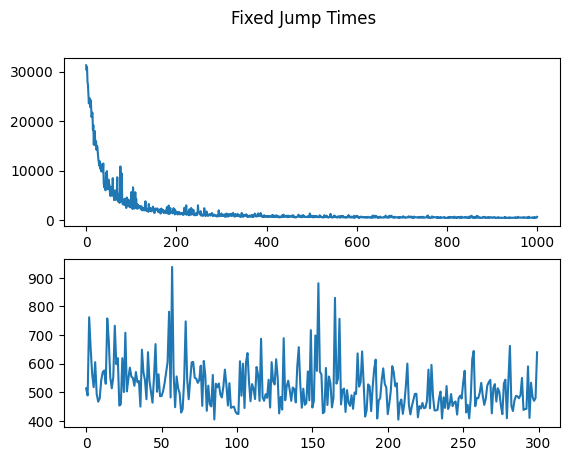

In [268]:
plot_losses(svi_free)
plt.suptitle("Free Jump Times")
plot_losses(svi_fixed)
plt.suptitle("Fixed Jump Times")
pass

In [269]:
def logged_model(argless_model):
    with SOLVER, LogTrajectory(times=torch.linspace(START_T, END_T, RES)) as lt:
        return argless_model(), lt

In [270]:
predictive_model_free = PredictiveModel(partial(logged_model, argless_model=pjm_free_jump_times), svi_free.guide)
predictive_model_fixed = PredictiveModel(partial(logged_model, argless_model=pjm_fixed_jump_times), svi_fixed.guide)

In [271]:
def plot_predictive(predictive_model):
    jump_times_learned, lt_learned = predictive_model()
    
    plot_trajectory(lt_learned, data_sub, jump_times_learned, data_times=time_sub, jump_lw=0.2)
    # Plot the original trajectory in dashed black.
    plt.plot(lt.times, lt.trajectory['y'].detach(), color='black', linestyle='--', linewidth=0.5)

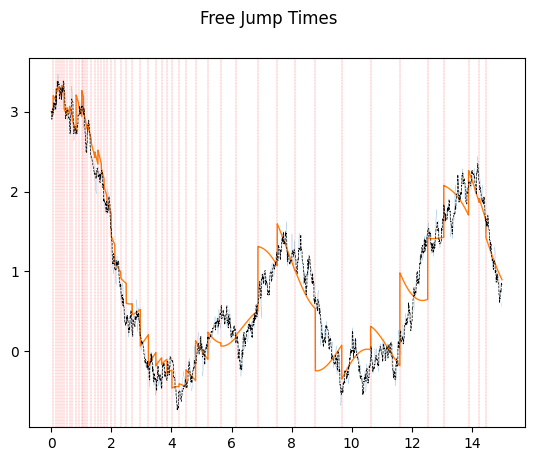

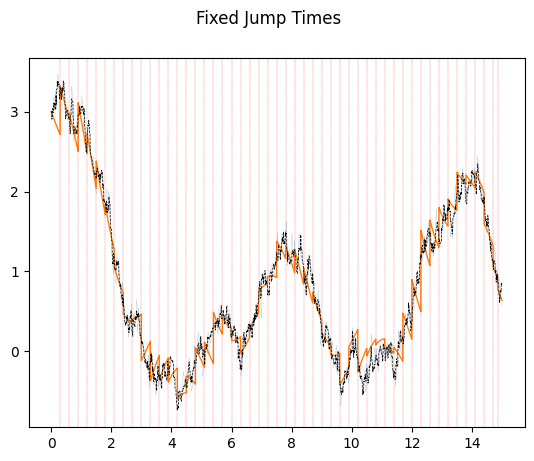

In [272]:
plot_predictive(predictive_model_free)
plt.suptitle("Free Jump Times")
plot_predictive(predictive_model_fixed)
plt.suptitle("Fixed Jump Times")
pass

In [273]:
def plot_posterior_approx(svi):
    with pyro.plate("samples", 1000, dim=-3):
        samples = svi.guide()
    fig, ax = plt.subplots(3, 1, figsize=(5, 5), dpi=100)
    for i, param_name in enumerate(["frequency", "amplitude", "decay"]):
        param_val = samples[param_name]
        ax[i].hist(param_val.squeeze().detach(), bins=50)
        ax[i].set_xlabel(param_name)
        ax[i].axvline(TRUE_COEFS[param_name].item(), color='red')

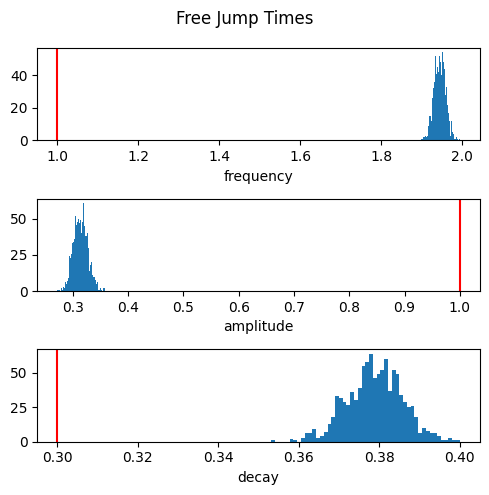

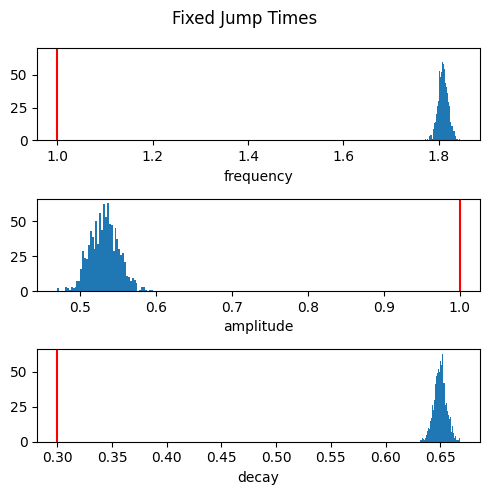

In [274]:
plot_posterior_approx(svi_free)
plt.suptitle("Free Jump Times")
plt.tight_layout()
plot_posterior_approx(svi_fixed)
plt.suptitle("Fixed Jump Times")
plt.tight_layout()
pass

# Issues and Hypotheses

1. This is a very non-linear problem with many local optima (as is evidenced by the decent fits but very poor parameter recovery).
2. Fewer jumps lead to more non-linearities and multiple local optima? Larger individual jumps can account for incorrect parameters. More jumps require a larger number of jumps to violate the noise priors, which increases the responsibility of the deterministic dynamics in fitting the data. The downside, of course, is computational in that each jump requires a separate solve. Is there a way to enforce an assumption that the jump noise should not be correlated? That could go a long ways in addressing the problem.
3. More jumps, however, at least when the jump time is allowed to vary, seem to concentrate jumps in areas with large time derivatives that aren't properly accounted for by the parameters (see, for example, the beginning part of this series that involves rapid decay to zero). They might also just be concentrating at the beginning because of pathologies arising from the discontinuities. Maybe they are getting signal to move backward, but never any signal to move forward?
3. The likelihood is discontinuous in the jump times because a jump can discontinuously include or exclude observed data (e.g. passing it off to the previous jump) by moving the jump time slightly. That said, it can still receive some gradient signal if making a jump sooner (or later) would better fit data that sits in the deterministic window following the jump. It might be equally effective (with many jumps) to just fix the jump times. One could also fix a jump time at each observed data point — this would be at least as capable as a set of time-varying jump times, though obviously won't scale well. That said, there might be a way to relax the discrete jump times in a way that mitigates this issue. For example, we could interpret jumps as immediately preceding subsets of the observed data, which might allow for a continuous mixture, of sorts, wherein mixing coefficients determine which of a discrete set of possible jump times best fits the data.
4. The current approach for translating between noise-per-time-unit and the jump-noise seems incorrect. 100 small jumps with a local standard deviation of 0.01 will, on average, result in less "travel" than a single jump with a local standard deviation of 1.0. The model needs to account for the fact that multiple jumps will converge to the mean. This is related to #1. Need to review the brownian bridge stuff...
5. There's a strange divergences during optimization with free jump times (see the loss plot). I'm not sure what causes this.
6. To try: interventions that just explicitly intervene on the state to return it to the mean of some sliding-window average of the observed data. This would take a significant degree of freedom out of the equation, at least during training. This could be relaxed at the end in a post-training cycle where just the jump noises are learned. Naturally, the total loss under this approach (now just wrt the jump times and latent dynamics parameters) would need to reflect this manual jump noise update, which is perhaps best interpreted as using an analytical global optimization routine for the jump noises. Side question: under this strategy, would you actually need to add artificial observation noise to the data? At least heuristically, the priors on the analytically derived jump noises would, in practice, induce a loss-like term that would require dynamics parameters to reduce the burden on the jump noises. *This approach also would prevent jump noises from doing anything besides fitting their time-local data, as opposed to adjusting their jump times in a way that poorly fits their time-local data, but allows for an otherwise poor estimate of the latent dynamics parameters to better fit data later on in the time series.*

In [315]:
# Try again with the guide initialized to the true parameter values (so-as to see if the truth is indeed an optimum) and zero jump noise.
# Use fixed jump times.
values_for_guide_init = {
    **TRUE_COEFS,
    **{f"jump{i}": torch.tensor(0.0) for i in range(TRAIN_NUM_JUMPS)}
}
svi_fixed_true_init = build_svi(
    partial(conditioned_model, argless_model=pjm_fixed_jump_times),
    init_loc_fn=pyro.infer.autoguide.init_to_value(values=values_for_guide_init)
)

In [322]:
nbefore = len(svi_fixed_true_init.losses)
for i in range(NITER):
    svi_fixed_true_init.step()
    print(f"Progress {nbefore + i + 1}/{nbefore + NITER}", end='\r')

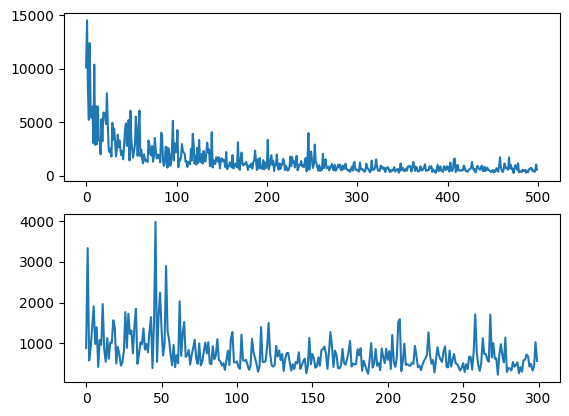

In [323]:
plot_losses(svi_fixed_true_init)

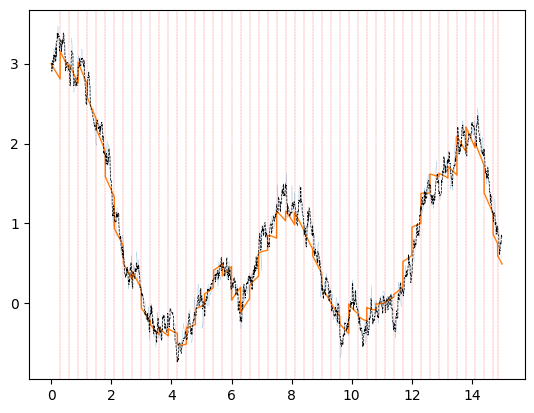

In [324]:
plot_predictive(PredictiveModel(partial(logged_model, argless_model=pjm_fixed_jump_times), svi_fixed_true_init.guide))

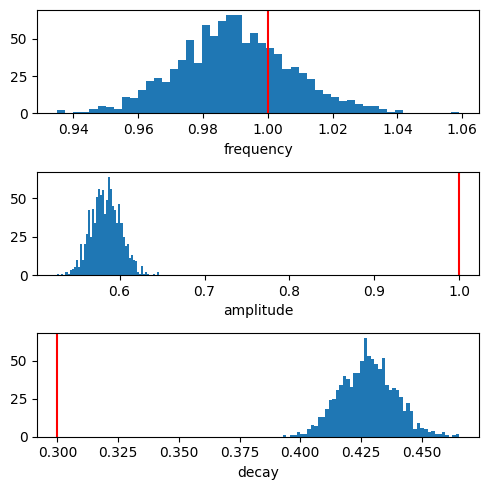

In [325]:
plot_posterior_approx(svi_fixed_true_init)
plt.tight_layout()

This is marginally better, but not great. See #7 above for what I think is the most promising solution? But below we'll try just more jumps.

In [331]:
pjm_more_jumps = partial(
    stochastic_jump_model,
    num_jumps=200,
    start_time=torch.tensor(START_T),
    end_time=torch.tensor(END_T),
    noise_per_time_unit=NOISE_PER_TIME_UNIT,
    fix_jump_times=True
)

In [332]:
values_for_guide_init_more_jumps = {
    **TRUE_COEFS,
    **{f"jump{i}": torch.tensor(0.0) for i in range(200)}
}

svi_fixed_true_init_more_jumps = build_svi(
    partial(conditioned_model, argless_model=pjm_more_jumps),
    init_loc_fn=pyro.infer.autoguide.init_to_value(values=values_for_guide_init_more_jumps)
)

In [338]:
nbefore = len(svi_fixed_true_init_more_jumps.losses)
for i in range(NITER):
    svi_fixed_true_init_more_jumps.step()
    print(f"Progress {nbefore + i + 1}/{nbefore + NITER}", end='\r')

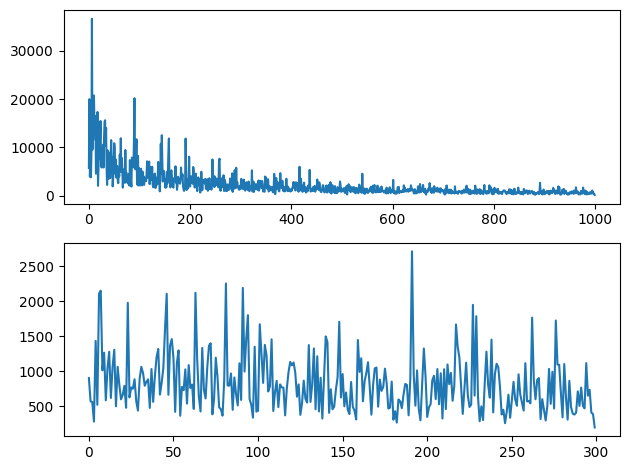

In [339]:
plot_losses(svi_fixed_true_init_more_jumps)
plt.tight_layout()

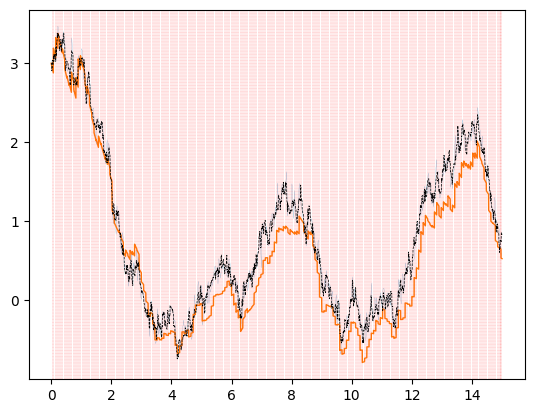

In [340]:
plot_predictive(PredictiveModel(partial(logged_model, argless_model=pjm_more_jumps), svi_fixed_true_init_more_jumps.guide))

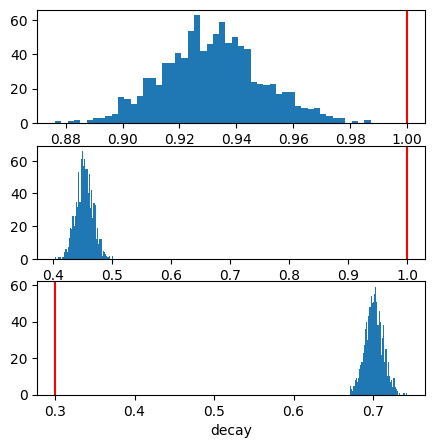

In [341]:
plot_posterior_approx(svi_fixed_true_init_more_jumps)

Nope, didn't help.